In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
#np.set_printoptions(threshold=sys.maxsize)
from scipy.signal import find_peaks, peak_widths
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from pandas import read_csv
from scipy import signal

In [363]:
data = pd.read_csv('051622 Sample 1.txt', delimiter='\t', header=None)
pv = data[1].to_numpy()
T_s = data[0][1] - data[0][0]
timestamp = np.arange(start = 0, stop = len(pv)*T_s, step = T_s)
timestamp = timestamp[np.logical_not(np.isnan(timestamp))]
timestamp -= timestamp[0]

f_s = 1/T_s
increment_s = 0.01
timestamp_ds = np.arange(0, timestamp[-1], increment_s)

In [356]:
#decompose series
from statsmodels.tsa.seasonal import seasonal_decompose

def det_sea(sig, window_length_sa=20, period=100):
    sig_dec = seasonal_decompose(sig, model='additive', period=period)
    sig_adj = sig - sig_dec.seasonal - np.nan_to_num(sig_dec.trend)
    sig_den = np.convolve(sig_adj, np.ones(window_length_sa)/window_length_sa, mode='same')
    return sig_den

# red
red_offset_s = 0.001
red = pv[int(red_offset_s*f_s):-1:int(increment_s*f_s)]
red_den = det_sea(red)

# nir
nir_offset_s = 0.006
nir = pv[int(nir_offset_s*f_s):-1:int(increment_s*f_s)]
decompose_series = seasonal_decompose(nir, model='additive',period=100)
nir_den = det_sea(nir)


In [247]:
peaks_red, _ = find_peaks(-red_den, distance=100)
peaks_nir, _ = find_peaks(-nir_den, distance=100)
adj_peaks_red = np.concatenate(([0],
                                np.sort(np.row_stack([peaks_red, peaks_red+1]).flatten()),
                                [timestamp_ds[-1]/0.01])).reshape(-1,2).astype(int)
adj_peaks_nir = np.concatenate(([0],
                                np.sort(np.row_stack([peaks_nir, peaks_nir+1]).flatten()),
                                [timestamp_ds[-1]/0.01])).reshape(-1,2).astype(int)
max_length_red = (adj_peaks_red[:,1]-adj_peaks_red[:,0]).max() # max length of denoised slices
n_slices_red = len(adj_peaks_red) # number of slices
max_length_nir = (adj_peaks_nir[:,1]-adj_peaks_nir[:,0]).max() # max length of denoised slices
n_slices_nir = len(adj_peaks_nir) # number of slices



In [249]:
#initialize
slices_red = []
slices_nir = []
for i in range(n_slices_red):
    length_now_red = (adj_peaks_red[i,1]-adj_peaks_red[i,0])
    if length_now_red < max_length_red:
        slices_red.append(np.pad(red_den[adj_peaks_red[i,0]:adj_peaks_red[i,1]], (0, max_length_red-length_now_red), 'constant', constant_values = 0))
    else:
        slices_red.append(red_den[adj_peaks_red[i,0]:adj_peaks_red[i,1]])

for i in range(n_slices_nir):
    length_now_nir = (adj_peaks_nir[i,1]-adj_peaks_nir[i,0])
    if length_now_nir < max_length_nir:
        slices_nir.append(np.pad(nir_den[adj_peaks_nir[i,0]:adj_peaks_nir[i,1]], (0, max_length_nir-length_now_nir), 'constant', constant_values = 0))
    else:
        slices_nir.append(nir_den[adj_peaks_nir[i,0]:adj_peaks_nir[i,1]])

slices_red = np.array(slices_red)
slices_nir = np.array(slices_nir)


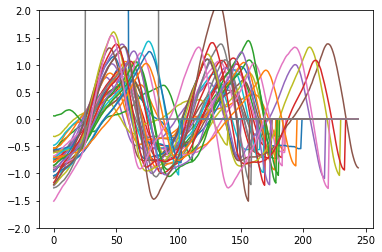

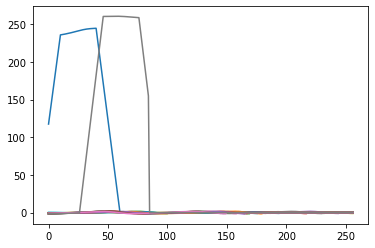

In [368]:
#plot for slices_red
for i in range(n_slices_red):
    plt.plot(slices_red[i])
#plt.ylim(-2,2)
plt.show()

#plot for slices_nir
for i in range(n_slices_nir):
    plt.plot(slices_nir[i])
#plt.ylim(-2,2)
plt.show()


In [251]:
#normalization, base line  -1,1
#remove curves with too many zeros
#pick a shortest curve, for any other curves longer than it, eg, 20 units longer, than remove a dot each 20 unit


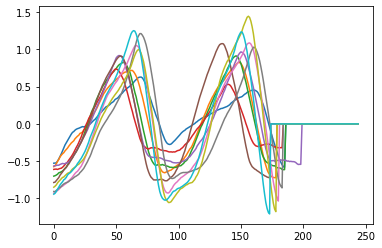

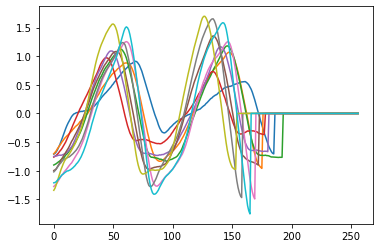

In [319]:
#from scipy.signal import argrelextrema
#distance 50, 50*0.01s = 0.5s, so 120 heartbeats / min

red_peaks = []
for i in range (n_slices_red):
    peaks_red_new, _ = find_peaks(slices_red[i], distance=50)
    if len(peaks_red_new) > 2 or (np.count_nonzero(slices_red[i] > 150)):
      red_peaks.append(i)
slices_red_twopeak = np.delete(slices_red, red_peaks, 0)

red_peaks_zero = []
for i, arr in enumerate(slices_red_twopeak):
    if (arr[100:] == 0).sum() >= 75:
      red_peaks_zero.append(i)
slices_red_twopeak_nonzero = np.delete(slices_red_twopeak, red_peaks_zero, 0)

for i in range(len(slices_red_twopeak_nonzero)):
    plt.plot(slices_red_twopeak_nonzero[i])
plt.show()


#nir_peaks = []
#for i in range (n_slices_nir):
#    peaks_nir_new, _ = find_peaks(slices_nir[i], distance=50)
#    if len(peaks_nir_new) > 2 or (np.count_nonzero(slices_nir[i] > 150)):
#      nir_peaks.append(i)
slices_nir_twopeak = np.delete(slices_nir, red_peaks, 0)

#nir_peaks_zero = []
#for i, arr in enumerate(slices_nir_twopeak):
#    if (arr[100:] == 0).sum() >= 75:
#      nir_peaks_zero.append(i)
slices_nir_twopeak_nonzero = np.delete(slices_nir_twopeak, red_peaks_zero, 0)

for i in range(len(slices_nir_twopeak_nonzero)):
    plt.plot(slices_nir_twopeak_nonzero[i])
plt.show()

10

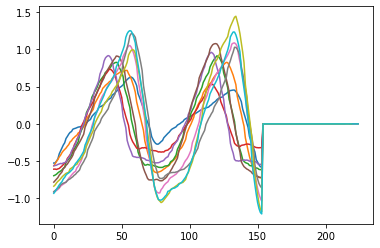

/var/folders/l7/h3nhqt8n2rl5hxy9gsqrk58r0000gn/T/ipykernel_22580/862189453.py:48: RuntimeWarning: divide by zero encountered in long_scalars
  delete_nir_index = np.arange(0,x_nir,x_nir/y_nir).astype(int)


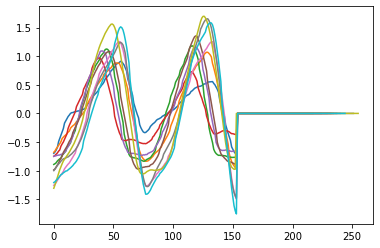

In [360]:
#adjust curves to have same length

def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

sum_red_zeros = []
sum_nir_zeros = []
sum_all_zeros = []
delete_red_index = []
delete_nir_index = []
normalized_red = []
normalized_nir = []
for i in range (len(slices_red_twopeak_nonzero)):
    sum_red_zeros.append(np.sum(zero_runs(slices_red_twopeak_nonzero[i])[:,1] - zero_runs(slices_red_twopeak_nonzero[i])[:,0]))
    sum_nir_zeros.append(np.sum(zero_runs(slices_nir_twopeak_nonzero[i])[:,1] - zero_runs(slices_nir_twopeak_nonzero[i])[:,0]))
    sum_all_zeros = sum_red_zeros+sum_nir_zeros
if max(sum_red_zeros) < max(sum_nir_zeros):
    max_all_zeros_red = max_length_red - max_length_nir + max(sum_nir_zeros)
    max_all_zeros_nir = max(sum_nir_zeros)
elif max(sum_red_zeros) > max(sum_nir_zeros):
    max_all_zeros_nir = max_length_nir - max_length_red + max(sum_red_zeros)
    max_all_zeros_red = max(sum_red_zeros)
elif max(sum_red_zeros) == max(sum_nir_zeros):
    max_all_zeros_red = max(sum_red_zeros)
    max_all_zeros_nir = max_all_zeros_red

for i in range (len(slices_red_twopeak_nonzero)):
    x_red = len(slices_red_twopeak_nonzero[i])-sum_red_zeros[i]
    y_red = max_all_zeros_red-sum_red_zeros[i]
    delete_red_index = np.arange(0,x_red,x_red/y_red).astype(int)
    normalized_red.append((2*(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0)-min(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0)))/((max(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0)) - min(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0)))))-1)
    plt.plot(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0))
plt.show()


#for i in range (len(slices_nir_twopeak_nonzero)):
#    sum_red_zeros.append(np.sum(zero_runs(slices_red_twopeak_nonzero[i])[:,1] - zero_runs(slices_red_twopeak_nonzero[i])[:,0]))
#    sum_nir_zeros.append(np.sum(zero_runs(slices_nir_twopeak_nonzero[i])[:,1] - zero_runs(slices_nir_twopeak_nonzero[i])[:,0]))
#    sum_all_zeros = sum_red_zeros+sum_nir_zeros
for i in range (len(slices_nir_twopeak_nonzero)):
    x_nir = len(slices_nir_twopeak_nonzero[i])-sum_nir_zeros[i]
    y_nir = max_all_zeros_nir-sum_nir_zeros[i]
    delete_nir_index = np.arange(0,x_nir,x_nir/y_nir).astype(int)
    normalized_nir.append((2*(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0)-min(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0)))/((max(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0)) - min(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0)))))-1)
    plt.plot(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0))
plt.show()


#gz file

In [358]:
max(sum_red_zeros)

71

In [354]:
sum_red_zeros

[59, 66, 59, 61, 46, 71, 64, 61, 66, 71]

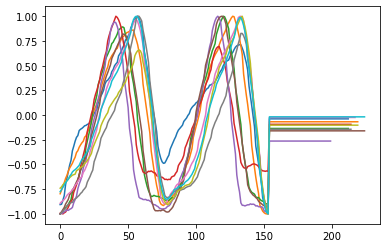

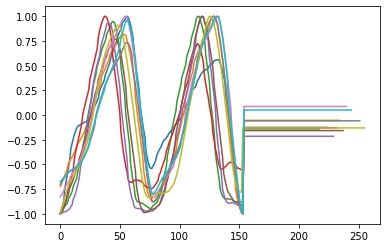

In [357]:
#plot for normalized data
for i in range (len(normalized_red)):
    plt.plot(normalized_red[i])
plt.show()
for i in range (len(normalized_nir)):
    plt.plot(normalized_nir[i])
plt.show()

In [ ]:
#init

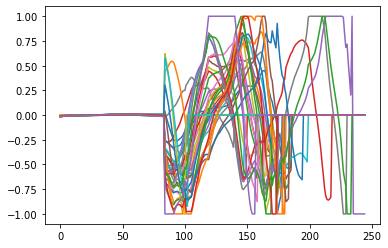

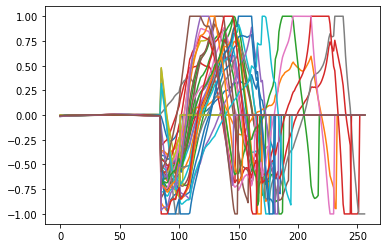

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

transformer_red = MaxAbsScaler().fit(slices_red)
MaxAbsScaler()
normal_slices_red = transformer_red.transform(slices_red)
for i in range(1, n_slices_red-2):
    plt.plot(normal_slices_red[i])
plt.show()

transformer_nir = MaxAbsScaler().fit(slices_nir)
MaxAbsScaler()
normal_slices_nir = transformer_nir.transform(slices_nir)
for i in range(1, n_slices_nir-1):
    plt.plot(normal_slices_nir[i])
plt.show()
